In [439]:
import pandas as pd #lectura de datos
import numpy as np # biblioteca con operaciones matemáticas y algebra lineal
import mysql.connector # importar la base de datos


#viz y plots bonitos
import matplotlib.pyplot as plt
import seaborn as sbn
plt.style.use('ggplot')
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams[u'figure.figsize'] = (16,12)
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large'}
plt.rcParams.update(params)

# preprocesamiento de datos
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

#tuneo de metaparametros
from sklearn.model_selection import GridSearchCV

# Modelos
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier

# metricas de evaluacion
from sklearn.metrics import (roc_auc_score, classification_report, confusion_matrix,
                            roc_curve, accuracy_score)
# lo mismo pero en grafico
import scikitplot as skplt

# Interpretacion
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import shap

In [812]:
cnx = mysql.connector.connect(
        user='ligamx_scrapper', 
        password='1234qwer', # note apures... nunca uso esa contrasenia :v
        host='localhost',
        database='ligamx')

#https://github.com/geroblesv/ligamx_scrapper   de aqui es el scrapper

In [819]:
# Lectura de datos desde la tabla
df = pd.read_sql_query("SELECT * FROM ligamx.match;", con=cnx)
df["match_date"] = pd.to_datetime(df.match_date)
df = df.sort_values('match_date').reset_index(drop=True) # se ordena de lo mas viejo a lo mas nuevo en partidos
# Variable si depende del mes y dia que juegan
df["match_year"] = df.match_date.dt.year
dict_month = {1:'Enero',2:'Febrero',3:'Marzo',4:'Abril',5:'Mayo',6:'Junio',7:'Julio',
             8:'Agosto',9:'Septiembre',10:'Octubre',11:'Noviembre',12:'Diciembre'}
df["match_month"] = df.match_date.dt.month.map(dict_month)
dict_day = {0:'Lunes',1:'Martes',2:'Miercoles',3:'Jueves',4:'Viernes',5:'Sabado',6:'Domingo'}
df["match_diasemana"] = df.match_date.dt.weekday.map(dict_day)
# Checamos que los nombres no esten repetidos
team_dict = {'Gallos Blancos':'Club Queretaro','Laguna':'Santos','América':'America',
             'Atlético Español':'Atletico Espanol','León':'Leon','Ángeles':'Angeles',
            'Club Querétaro':'Club Queretaro','Atlético de San Luis':'Atletico de San Luis',
            'FC Juárez':'FC Juarez'}
df.home_team = df.home_team.apply(lambda x: team_dict.get(x,x))
df.away_team = df.away_team.apply(lambda x: team_dict.get(x,x))
# Guardamos el resultado que sera nuestra variable a predecir al hacerlo multiclase
df['resultado'] = np.where(df.home_score > df.away_score, 'local',
                          np.where(df.home_score == df.away_score, 'empate',
                                  'visitante'))
# Resultado en formato
df['FT'] = df.home_score.astype(str) + '-' + df.away_score.astype(str)

In [821]:
# Se crea la variable a predecir
df['ganador'] = np.where(df.home_score > df.away_score, df.home_team,
                          np.where(df.home_score == df.away_score, 'empate',
                                  df.away_team))

# Como es nuestra variable objetivo

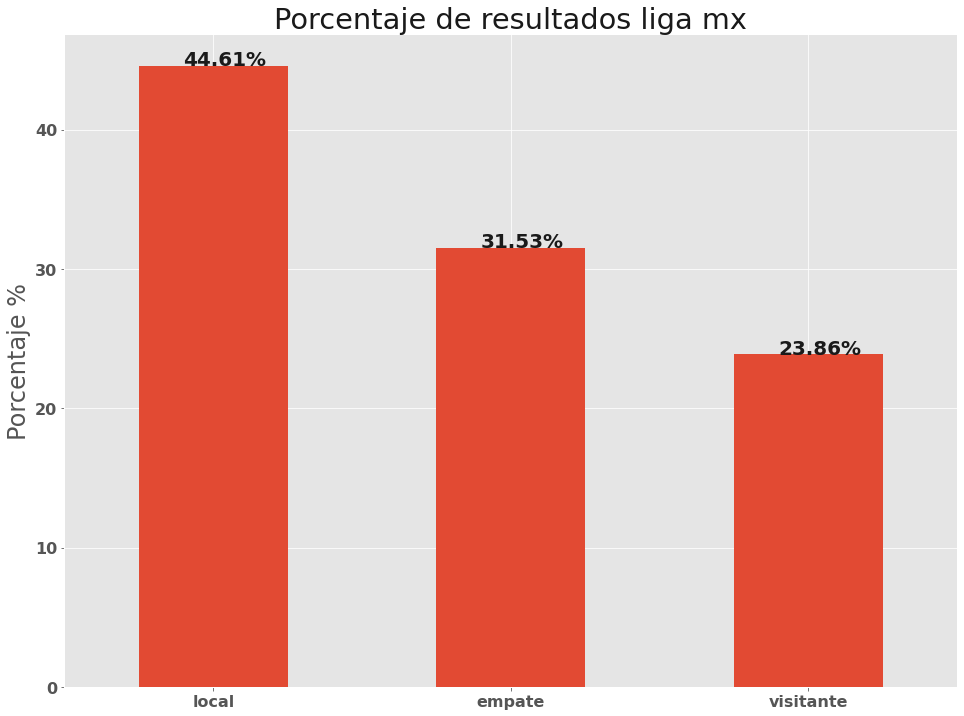

In [822]:
res = df.resultado.value_counts(normalize=True) * 100
res.plot.bar(rot=0, title='Porcentaje de resultados liga mx')
plt.ylabel('Porcentaje %')
for ind,i in enumerate(res.values):
    plt.text(ind-0.1,i,str(round(i,2))+'%')

Hagamos mas cosas y ahorita regresamos a ti!

# Solo por hobbie hagamos una carrera de barras

In [823]:
import bar_chart_race as bcr
# necesario instalar ffmepg, hit utiliza conda...! funciona

In [824]:
# creamos un par de columnas para mejorar la visualizacion
df['year_month'] = pd.to_datetime(df.match_date).dt.to_period('m')
df['es_liguilla'] = np.where(df.match_name.str[:7] != 'Jornada',1,0)

In [827]:
# Preprocesamiento de datos.
df_bar_race = df[df['es_liguilla'] != 1]
df_bar_race = df.groupby("year_month").ganador.value_counts().unstack(1)
df_bar_race = df_bar_race.reset_index().set_index("year_month").fillna(0).cumsum()
df_bar_race.index = df_bar_race.index.to_timestamp()
df_bar_race.drop(['empate','Angeles','Atletico Espanol','Campesinos','Cobras','Correcaminos',
                 'Cuernavaca','Indios','La Piedad','Tampico Madero','Atletico de San Luis'],axis=1,inplace=True)

In [828]:
# Cosas de la carrera de barras
def period_summary(values, ranks):
    top2 = values.nlargest(2)
    leader = top2.index[0]
    lead = top2.iloc[0] - top2.iloc[1]
    s = f'{leader} by {lead:.0f}'
    return {'s': s, 'x': .95, 'y': .07, 'ha': 'right', 'size': 8}

bcr.bar_chart_race(df=df_bar_race, 
                   filename= None, #'ligamx_winners.mp4', 
                   n_bars=10, 
                   period_fmt = ' %B %Y', 
                   title='Partidos ganados acumulados de la Liga MX 1975-2019 sin liguillas',
                   bar_label_size=7,
                   tick_label_size=8,
                   steps_per_period=6,
                   bar_kwargs={'alpha': .7},
                   period_summary_func=period_summary,
                   perpendicular_bar_func='median',
                   scale='linear',
                   cmap=['yellow','blue','gold','red','navy','red','aqua',
                   'brown','red','snow','greenyellow','aqua','orangered',
                   'deepskyblue','limegreen','lightcoral','b','darkred','navy','white',
                   'chocolate','lawngreen','darksalmon','silver','gray','navy','lightgreen','firebrick',
                   'royalblue','w','cornflowerblue','dodgerblue','olive','palegreen'
                   ,'yellow','r','crimson','chartreuse','seashell'],
                   filter_column_colors=False)

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


# Generacion de variables

In [829]:
cols_checks = ['home_team', 'FT','away_team','resultado','historico_racha_ganadora_local','historico_racha_ganadora_visitante']
df.head()

match_date      tournament_name  match_name         home_team  home_score  \
0 1975-07-01  temporada 1975 1976  Jornada 36           America           2   
1 1975-07-03  temporada 1975 1976  Jornada 36         Monterrey           1   
2 1975-07-03  temporada 1975 1976  Jornada 36  Atletico Espanol           3   
3 1975-07-03  temporada 1975 1976  Jornada 36           Jalisco           3   
4 1975-07-04  temporada 1975 1976  Jornada 36            Toluca           4   

     away_team  away_score  match_year match_month match_diasemana  resultado  \
0        Pumas           1        1975       Julio          Martes      local   
1  Estudiantes           2        1975       Julio          Jueves  visitante   
2      Atlante           0        1975       Julio          Jueves      local   
3       Tigres           2        1975       Julio          Jueves      local   
4    Zacatepec           0        1975       Julio         Viernes      local   

    FT           ganador year_month  es_liguilla  
0  2-1           America    1975-07            0  
1  1-2       Estudiantes    1975-07            0  
2  3-0  Atletico Espanol    1975-07            0  
3  3-2           Jalisco    1975-07            0  
4  4-0            Toluca    1975-07            0

## racha de partidos ganados

In [830]:
# suma de goles del equipo en el partido actual durante el torneo
df_racha = pd.DataFrame()
for tornament in df.tournament_name.unique():
    
    df_res = df[df.tournament_name == tornament]
    el = df_res.home_team.unique()

    df_res = df_res[['tournament_name','match_date','home_team','away_team', 'resultado','ganador', 'FT']]
    df_res['historico_racha_ganadora_local'] = np.nan
    df_res['historico_racha_ganadora_visitante'] = np.nan
    
    for e1 in el:

        num_ganes = 0
        ind_local = df_res[df_res.home_team == e1].index.values
        ind_visitante = df_res[df_res.away_team == e1].index.values
        ind = sorted(df_res[(df_res.home_team == e1) | (df_res.away_team == e1)].index.values)
        ind_mas_uno = 0

        for match in ind:
    
            # se ponen los goles anteriores al partido actual para evitar el future leak.
            if ind[ind_mas_uno] in ind_local:
                df_res.loc[ind[ind_mas_uno], 'historico_racha_ganadora_local'] = num_ganes
            elif ind[ind_mas_uno] in ind_visitante:
                df_res.loc[ind[ind_mas_uno], 'historico_racha_ganadora_visitante'] = num_ganes

            # suma de goles
            if match in ind_local:
                if df_res.loc[match, 'resultado'] == 'local':
                    num_ganes = num_ganes + 1
                    ind_mas_uno = ind_mas_uno + 1
                else:
                    num_ganes = 0
                    ind_mas_uno = ind_mas_uno + 1

            elif match in ind_visitante:
                if df_res.loc[match, 'resultado'] == 'visitante':
                    num_ganes = num_ganes + 1
                    ind_mas_uno = ind_mas_uno + 1
                else:
                    num_ganes = 0
                    ind_mas_uno = ind_mas_uno + 1

    df_racha = pd.concat([df_racha,df_res])

In [831]:
df_racha[(
    df_racha.home_team == 'Pumas')|(df_racha.away_team == 'Pumas')]

tournament_name match_date         home_team   away_team resultado  \
0      temporada 1975 1976 1975-07-01           America       Pumas     local   
10     temporada 1975 1976 1975-07-08  Atletico Espanol       Pumas     local   
20     temporada 1975 1976 1975-07-15             Pumas        Leon     local   
30     temporada 1975 1976 1975-07-21        Curtidores       Pumas     local   
33     temporada 1975 1976 1975-07-24             Pumas  Curtidores     local   
...                    ...        ...               ...         ...       ...   
12755        apertura 2019 2019-10-26    Club Queretaro       Pumas     local   
12764        apertura 2019 2019-10-29             Pumas       Atlas     local   
12770        apertura 2019 2019-11-01            Puebla       Pumas    empate   
12786        apertura 2019 2019-11-10             Pumas   FC Juarez    empate   
12790        apertura 2019 2019-11-23           Pachuca       Pumas     local   

                ganador   FT  historico_racha_ganadora_local  \
0               America  2-1                             0.0   
10     Atletico Espanol  1-0                             1.0   
20                Pumas  3-2                             0.0   
30           Curtidores  3-0                             0.0   
33                Pumas  2-1                             0.0   
...                 ...  ...                             ...   
12755    Club Queretaro  3-0                             2.0   
12764             Pumas  5-1                             0.0   
12770            empate  1-1                             0.0   
12786            empate  1-1                             0.0   
12790           Pachuca  2-0                             0.0   

       historico_racha_ganadora_visitante  
0                                     0.0  
10                                    0.0  
20                                    1.0  
30                                    1.0  
33                                    1.0  
...                                   ...  
12755                                 0.0  
12764                                 0.0  
12770                                 1.0  
12786                                 1.0  
12790                                 0.0  

[1396 rows x 9 columns]

## racha de partidos invicto

In [832]:
# suma de goles del equipo en el partido actual durante el torneo
df_racha_invicto = pd.DataFrame()
for tornament in df.tournament_name.unique():
    
    df_res = df[df.tournament_name == tornament]
    el = df_res.home_team.unique()

    df_res = df_res[['tournament_name','match_date','home_team','away_team', 'resultado','ganador', 'FT']]
    df_res['historico_invicto_local'] = np.nan
    df_res['historico_invicto_visitante'] = np.nan
    
    for e1 in el:

        num_ganes = 0
        ind_local = df_res[df_res.home_team == e1].index.values
        ind_visitante = df_res[df_res.away_team == e1].index.values
        ind = sorted(df_res[(df_res.home_team == e1) | (df_res.away_team == e1)].index.values)
        ind_mas_uno = 0

        for match in ind:
    
            # se ponen los goles anteriores al partido actual para evitar el future leak.
            if ind[ind_mas_uno] in ind_local:
                df_res.loc[ind[ind_mas_uno], 'historico_invicto_local'] = num_ganes
            elif ind[ind_mas_uno] in ind_visitante:
                df_res.loc[ind[ind_mas_uno], 'historico_invicto_visitante'] = num_ganes

            # suma de goles
            if match in ind_local:
                if df_res.loc[match, 'resultado'] in ['local','empate']:
                    num_ganes = num_ganes + 1
                    ind_mas_uno = ind_mas_uno + 1
                else:
                    num_ganes = 0
                    ind_mas_uno = ind_mas_uno + 1

            elif match in ind_visitante:
                if df_res.loc[match, 'resultado'] in ['visitante','empate']:
                    num_ganes = num_ganes + 1
                    ind_mas_uno = ind_mas_uno + 1
                else:
                    num_ganes = 0
                    ind_mas_uno = ind_mas_uno + 1

    df_racha_invicto = pd.concat([df_racha_invicto,df_res])

In [833]:
df_racha_invicto[(
    df_racha_invicto.home_team == 'Pumas')|(df_racha_invicto.away_team == 'Pumas')].tail(18)

tournament_name match_date             home_team  away_team  resultado  \
12629   apertura 2019 2019-07-20  Atletico de San Luis      Pumas  visitante   
12643   apertura 2019 2019-07-28                 Pumas     Necaxa      local   
12651   apertura 2019 2019-08-04                 Pumas     Tigres  visitante   
12655   apertura 2019 2019-08-09          Club Tijuana      Pumas      local   
12668   apertura 2019 2019-08-18                 Pumas   Veracruz      local   
12672   apertura 2019 2019-08-23               Morelia      Pumas      local   
12688   apertura 2019 2019-08-29             Monterrey      Pumas      local   
12695   apertura 2019 2019-09-01                 Pumas     Toluca      local   
12701   apertura 2019 2019-09-14               America      Pumas     empate   
12715   apertura 2019 2019-09-22                 Pumas  Cruz Azul     empate   
12731   apertura 2019 2019-09-29                 Pumas     Santos      local   
12738   apertura 2019 2019-10-05                Chivas      Pumas     empate   
12750   apertura 2019 2019-10-20                 Pumas       Leon  visitante   
12755   apertura 2019 2019-10-26        Club Queretaro      Pumas      local   
12764   apertura 2019 2019-10-29                 Pumas      Atlas      local   
12770   apertura 2019 2019-11-01                Puebla      Pumas     empate   
12786   apertura 2019 2019-11-10                 Pumas  FC Juarez     empate   
12790   apertura 2019 2019-11-23               Pachuca      Pumas      local   

              ganador   FT  historico_invicto_local  \
12629           Pumas  0-2                      0.0   
12643           Pumas  2-0                      1.0   
12651          Tigres  0-1                      2.0   
12655    Club Tijuana  1-0                      0.0   
12668           Pumas  2-0                      0.0   
12672         Morelia  2-0                      0.0   
12688       Monterrey  2-0                      0.0   
12695           Pumas  2-1                      0.0   
12701          empate  1-1                      0.0   
12715          empate  1-1                      2.0   
12731           Pumas  2-0                      3.0   
12738          empate  1-1                      0.0   
12750            Leon  1-2                      5.0   
12755  Club Queretaro  3-0                      2.0   
12764           Pumas  5-1                      0.0   
12770          empate  1-1                      0.0   
12786          empate  1-1                      2.0   
12790         Pachuca  2-0                      2.0   

       historico_invicto_visitante  
12629                          0.0  
12643                          1.0  
12651                          0.0  
12655                          0.0  
12668                          0.0  
12672                          1.0  
12688                          0.0  
12695                          2.0  
12701                          1.0  
12715                          2.0  
12731                          5.0  
12738                          4.0  
12750                          1.0  
12755                          0.0  
12764                          0.0  
12770                          1.0  
12786                          1.0  
12790                          3.0

## Historico goles

In [834]:
cols_checks = ['tournament_name','home_team', 'FT','away_team','resultado','historico_goles_local','historico_goles_visitante']

In [835]:
# suma de goles del equipo en el partido actual durante el torneo
df_goles = pd.DataFrame()
for tornament in df.tournament_name.unique():
    df_res = df[df.tournament_name == tornament]
    el = df_res.home_team.unique()
    df_res = df_res[['tournament_name','match_date','home_team','away_team',
                     'home_score','away_score','resultado','ganador', 'FT']]
    df_res['historico_goles_local'] = np.nan
    df_res['historico_goles_visitante'] = np.nan

    for e1 in el:
        
        try:
            goles = 0
            ind_local = df_res[df_res.home_team == e1].index.values
            ind_visitante = df_res[df_res.away_team == e1].index.values
            ind = sorted(df_res[(df_res.home_team == e1) | (df_res.away_team == e1)].index.values)
            ind_mas_uno = 0

            for match in ind:
                # suma de goles
                if match in ind_local:
                    goles = goles + df_res.loc[match,'home_score']
                    ind_mas_uno = ind_mas_uno + 1        
                elif match in ind_visitante:
                    goles = goles + df_res.loc[match, 'away_score']
                    ind_mas_uno = ind_mas_uno + 1

                # se ponen los goles anteriores al partido actual para evitar el future leak.
                if ind[ind_mas_uno] in ind_local:
                    df_res.loc[ind[ind_mas_uno], 'historico_goles_local'] = goles
                elif ind[ind_mas_uno] in ind_visitante:
                    df_res.loc[ind[ind_mas_uno], 'historico_goles_visitante'] = goles
        except IndexError:
            continue

    df_goles = pd.concat([df_goles,df_res])

In [836]:
df_goles[cols_checks][(df.tournament_name == 'apertura 2019' ) & ((
    df_goles.home_team == 'Pumas')|(df_goles.away_team == 'Pumas'))]

tournament_name             home_team   FT  away_team  resultado  \
12629   apertura 2019  Atletico de San Luis  0-2      Pumas  visitante   
12643   apertura 2019                 Pumas  2-0     Necaxa      local   
12651   apertura 2019                 Pumas  0-1     Tigres  visitante   
12655   apertura 2019          Club Tijuana  1-0      Pumas      local   
12668   apertura 2019                 Pumas  2-0   Veracruz      local   
12672   apertura 2019               Morelia  2-0      Pumas      local   
12688   apertura 2019             Monterrey  2-0      Pumas      local   
12695   apertura 2019                 Pumas  2-1     Toluca      local   
12701   apertura 2019               America  1-1      Pumas     empate   
12715   apertura 2019                 Pumas  1-1  Cruz Azul     empate   
12731   apertura 2019                 Pumas  2-0     Santos      local   
12738   apertura 2019                Chivas  1-1      Pumas     empate   
12750   apertura 2019                 Pumas  1-2       Leon  visitante   
12755   apertura 2019        Club Queretaro  3-0      Pumas      local   
12764   apertura 2019                 Pumas  5-1      Atlas      local   
12770   apertura 2019                Puebla  1-1      Pumas     empate   
12786   apertura 2019                 Pumas  1-1  FC Juarez     empate   
12790   apertura 2019               Pachuca  2-0      Pumas      local   

       historico_goles_local  historico_goles_visitante  
12629                    NaN                        NaN  
12643                    2.0                        0.0  
12651                    4.0                        4.0  
12655                    5.0                        4.0  
12668                    4.0                        4.0  
12672                    4.0                        6.0  
12688                    9.0                        6.0  
12695                    6.0                        4.0  
12701                   11.0                        8.0  
12715                    9.0                       10.0  
12731                   10.0                       26.0  
12738                   15.0                       12.0  
12750                   13.0                       26.0  
12755                   23.0                       14.0  
12764                   14.0                       17.0  
12770                   14.0                       19.0  
12786                   20.0                       15.0  
12790                   30.0                       21.0

## Goles en contra en cada partido

In [837]:
# suma de goles del equipo en el partido actual durante el torneo
df_goles_contra = pd.DataFrame()
for tornament in df.tournament_name.unique():
    df_res = df[df.tournament_name == tornament]
    el = df_res.home_team.unique()
    df_res = df_res[['tournament_name','match_date','home_team','away_team',
                     'home_score','away_score','resultado','ganador', 'FT']]
    df_res['historico_goles_contra_local'] = np.nan
    df_res['historico_goles_contra_visitante'] = np.nan

    for e1 in el:

        goles = 0
        ind_local = df_res[df_res.home_team == e1].index.values
        ind_visitante = df_res[df_res.away_team == e1].index.values
        ind = sorted(df_res[(df_res.home_team == e1) | (df_res.away_team == e1)].index.values)
        ind_mas_uno = 0

        for match in ind:
            try:
                # suma de goles
                if match in ind_local:
                    goles = goles + df_res.loc[match,'away_score']
                    ind_mas_uno = ind_mas_uno + 1        
                elif match in ind_visitante:
                    goles = goles + df_res.loc[match, 'home_score']
                    ind_mas_uno = ind_mas_uno + 1

                # se ponen los goles anteriores al partido actual para evitar el future leak.
                if ind[ind_mas_uno] in ind_visitante:
                    df_res.loc[ind[ind_mas_uno], 'historico_goles_contra_visitante'] = goles
                elif ind[ind_mas_uno] in ind_local:
                    df_res.loc[ind[ind_mas_uno], 'historico_goles_contra_local'] = goles

            except IndexError:
                continue
                
    df_goles_contra = pd.concat([df_goles_contra,df_res])

In [838]:
cols_checks = ['tournament_name','home_team', 'FT','away_team','resultado','historico_goles_contra_visitante','historico_goles_contra_local']

In [839]:
df_goles_contra[cols_checks][(df_goles_contra.tournament_name == 'apertura 2019' ) & ((
    df_goles_contra.home_team == 'Pumas')|(df_goles_contra.away_team == 'Pumas'))]

tournament_name             home_team   FT  away_team  resultado  \
12629   apertura 2019  Atletico de San Luis  0-2      Pumas  visitante   
12643   apertura 2019                 Pumas  2-0     Necaxa      local   
12651   apertura 2019                 Pumas  0-1     Tigres  visitante   
12655   apertura 2019          Club Tijuana  1-0      Pumas      local   
12668   apertura 2019                 Pumas  2-0   Veracruz      local   
12672   apertura 2019               Morelia  2-0      Pumas      local   
12688   apertura 2019             Monterrey  2-0      Pumas      local   
12695   apertura 2019                 Pumas  2-1     Toluca      local   
12701   apertura 2019               America  1-1      Pumas     empate   
12715   apertura 2019                 Pumas  1-1  Cruz Azul     empate   
12731   apertura 2019                 Pumas  2-0     Santos      local   
12738   apertura 2019                Chivas  1-1      Pumas     empate   
12750   apertura 2019                 Pumas  1-2       Leon  visitante   
12755   apertura 2019        Club Queretaro  3-0      Pumas      local   
12764   apertura 2019                 Pumas  5-1      Atlas      local   
12770   apertura 2019                Puebla  1-1      Pumas     empate   
12786   apertura 2019                 Pumas  1-1  FC Juarez     empate   
12790   apertura 2019               Pachuca  2-0      Pumas      local   

       historico_goles_contra_visitante  historico_goles_contra_local  
12629                               NaN                           NaN  
12643                               0.0                           0.0  
12651                               4.0                           0.0  
12655                               1.0                           5.0  
12668                              12.0                           2.0  
12672                               2.0                           8.0  
12688                               4.0                           9.0  
12695                               9.0                           6.0  
12701                               7.0                           8.0  
12715                              10.0                           8.0  
12731                              12.0                           9.0  
12738                               9.0                          20.0  
12750                              17.0                          10.0  
12755                              12.0                          14.0  
12764                              17.0                          15.0  
12770                              16.0                          27.0  
12786                              24.0                          17.0  
12790                              18.0                          26.0

### Diferencia de goles... Pero antes un merge de las variables!

In [840]:
df_semiall = df.merge(df_racha).merge(df_racha_invicto).merge(df_goles).merge(df_goles_contra).fillna(0)

In [841]:
df_semiall['historico_diferencia_goles_local'] = df_semiall.historico_goles_local - df_semiall.historico_goles_contra_local
df_semiall['historico_diferencia_goles_visitante'] = df_semiall.historico_goles_visitante - df_semiall.historico_goles_contra_visitante

In [842]:
cols_checks = ['tournament_name','home_team', 'FT','away_team','resultado',
               'historico_diferencia_goles_local','historico_diferencia_goles_visitante']

In [843]:
df_semiall[cols_checks][(df_semiall.tournament_name == 'apertura 2019' ) & ((
    df_semiall.home_team == 'Pumas')|(df_semiall.away_team == 'Pumas'))]

tournament_name             home_team   FT  away_team  resultado  \
12629   apertura 2019  Atletico de San Luis  0-2      Pumas  visitante   
12643   apertura 2019                 Pumas  2-0     Necaxa      local   
12651   apertura 2019                 Pumas  0-1     Tigres  visitante   
12655   apertura 2019          Club Tijuana  1-0      Pumas      local   
12668   apertura 2019                 Pumas  2-0   Veracruz      local   
12672   apertura 2019               Morelia  2-0      Pumas      local   
12688   apertura 2019             Monterrey  2-0      Pumas      local   
12695   apertura 2019                 Pumas  2-1     Toluca      local   
12701   apertura 2019               America  1-1      Pumas     empate   
12715   apertura 2019                 Pumas  1-1  Cruz Azul     empate   
12731   apertura 2019                 Pumas  2-0     Santos      local   
12738   apertura 2019                Chivas  1-1      Pumas     empate   
12750   apertura 2019                 Pumas  1-2       Leon  visitante   
12755   apertura 2019        Club Queretaro  3-0      Pumas      local   
12764   apertura 2019                 Pumas  5-1      Atlas      local   
12770   apertura 2019                Puebla  1-1      Pumas     empate   
12786   apertura 2019                 Pumas  1-1  FC Juarez     empate   
12790   apertura 2019               Pachuca  2-0      Pumas      local   

       historico_diferencia_goles_local  historico_diferencia_goles_visitante  
12629                               0.0                                   0.0  
12643                               2.0                                   0.0  
12651                               4.0                                   0.0  
12655                               0.0                                   3.0  
12668                               2.0                                  -8.0  
12672                              -4.0                                   4.0  
12688                               0.0                                   2.0  
12695                               0.0                                  -5.0  
12701                               3.0                                   1.0  
12715                               1.0                                   0.0  
12731                               1.0                                  14.0  
12738                              -5.0                                   3.0  
12750                               3.0                                   9.0  
12755                               9.0                                   2.0  
12764                              -1.0                                   0.0  
12770                             -13.0                                   3.0  
12786                               3.0                                  -9.0  
12790                               4.0                                   3.0

# Pre AED


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.

The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.


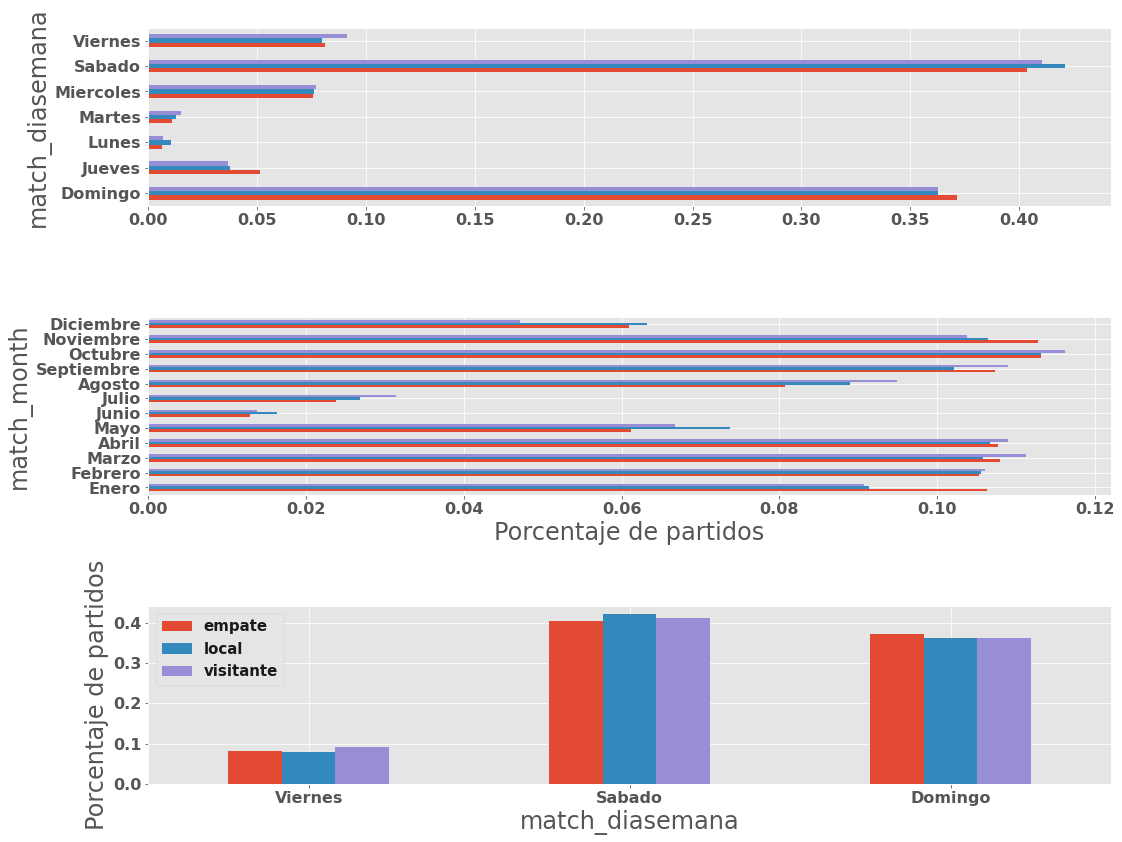

In [845]:
fig, ax = plt.subplots(3)

df.groupby("resultado").match_diasemana.value_counts(normalize=True).unstack(0).plot.barh(ax=ax[0], legend=False)

df.groupby("resultado").match_month.value_counts(
    normalize=True).unstack(0).loc[dict_month.values(),:].plot.barh(ax=ax[1], legend=False)
ax[1].set_xlabel("Porcentaje de partidos")

df.groupby("resultado").match_diasemana.value_counts(
    normalize=True).unstack(0).loc[['Viernes','Sabado','Domingo'],:].plot.bar(
    ax=ax[2], legend=True, rot=0)
ax[2].set_ylabel("Porcentaje de partidos")

plt.legend(fontsize=15)
plt.tight_layout()

In [846]:
# numero de empates
num_empates = [df[((df.home_team == team)|(df.away_team == team)) & (df.resultado == 'empate')
                 ].shape[0] for team in df.home_team.unique()]

In [847]:
empates_df = pd.DataFrame(index=df.home_team.unique(),data=num_empates,columns=['empates'])
partidos_df = df.groupby('resultado').ganador.value_counts().unstack(0).drop(
    'empate').drop('empate',axis=1).sort_values(
    ['local','visitante'],ascending=False)
partidos_df = partidos_df.join(empates_df)
partidos_df['num_partidos'] = partidos_df.sum(1)

partidos_df['perc_local'] = partidos_df.local/partidos_df.num_partidos
partidos_df['perc_visitante'] = partidos_df.visitante/partidos_df.num_partidos
partidos_df['perc_empate'] = partidos_df.empates/partidos_df.num_partidos

In [848]:
partidos_df.num_partidos.quantile(0.50)

249.0

In [849]:
from matplotlib.colors import LinearSegmentedColormap
clist = [(0.05, 0.05, 0.05), (0.1, 0.6, 1.0),  (0.8, 0.5, 0.1)]
cmap = LinearSegmentedColormap.from_list("cmap_name", clist)

Text(0.5, 81.0, 'Porcentaje partidos ganados de')

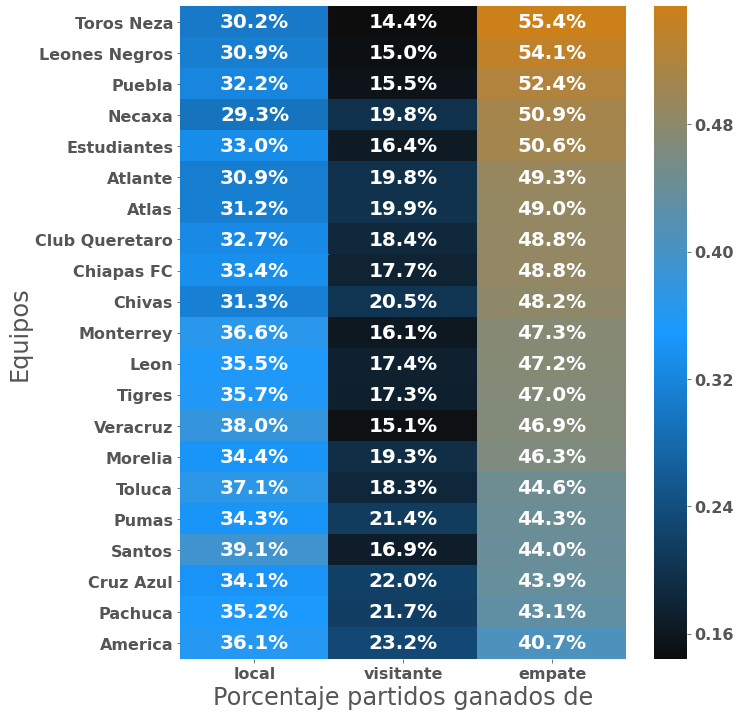

In [850]:
df['es_liguilla'] = np.where(df.match_name.str[:7] != 'Jornada',1,0)
partidos_df2 = partidos_df[partidos_df.num_partidos>250][['perc_local','perc_visitante','perc_empate']].sort_values(
    ['perc_empate','perc_local','perc_visitante'], ascending=False)
plt.figure(figsize=(10,12))
sbn.heatmap(partidos_df2,
            cmap=cmap, annot=True, fmt='.1%')
plt.xticks(ticks=[0.5,1.5,2.5], labels=['local','visitante','empate'],rotation=0)
plt.ylabel('Equipos')
plt.xlabel('Porcentaje partidos ganados de')

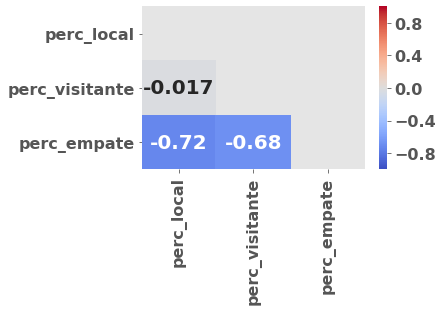

In [851]:
# Hay una correlacion entre ganar mas de local que de visitante...
corr = partidos_df2.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(5,3))
sbn.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1,vmax=1,
            mask=mask)
# al parecer.... NO

Text(0.5, 0, 'Porcentaje')

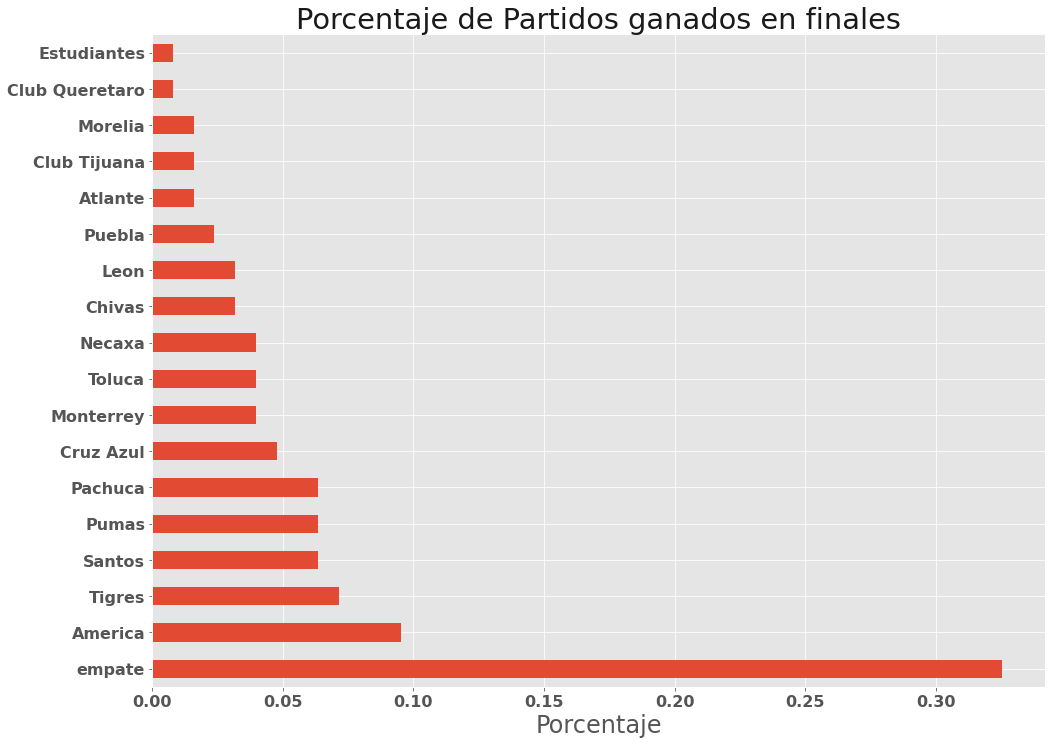

In [852]:
df[df.match_name == 'Final'].ganador.value_counts(normalize=True).plot.barh()
plt.title("Porcentaje de Partidos ganados en finales")
plt.xlabel("Porcentaje")

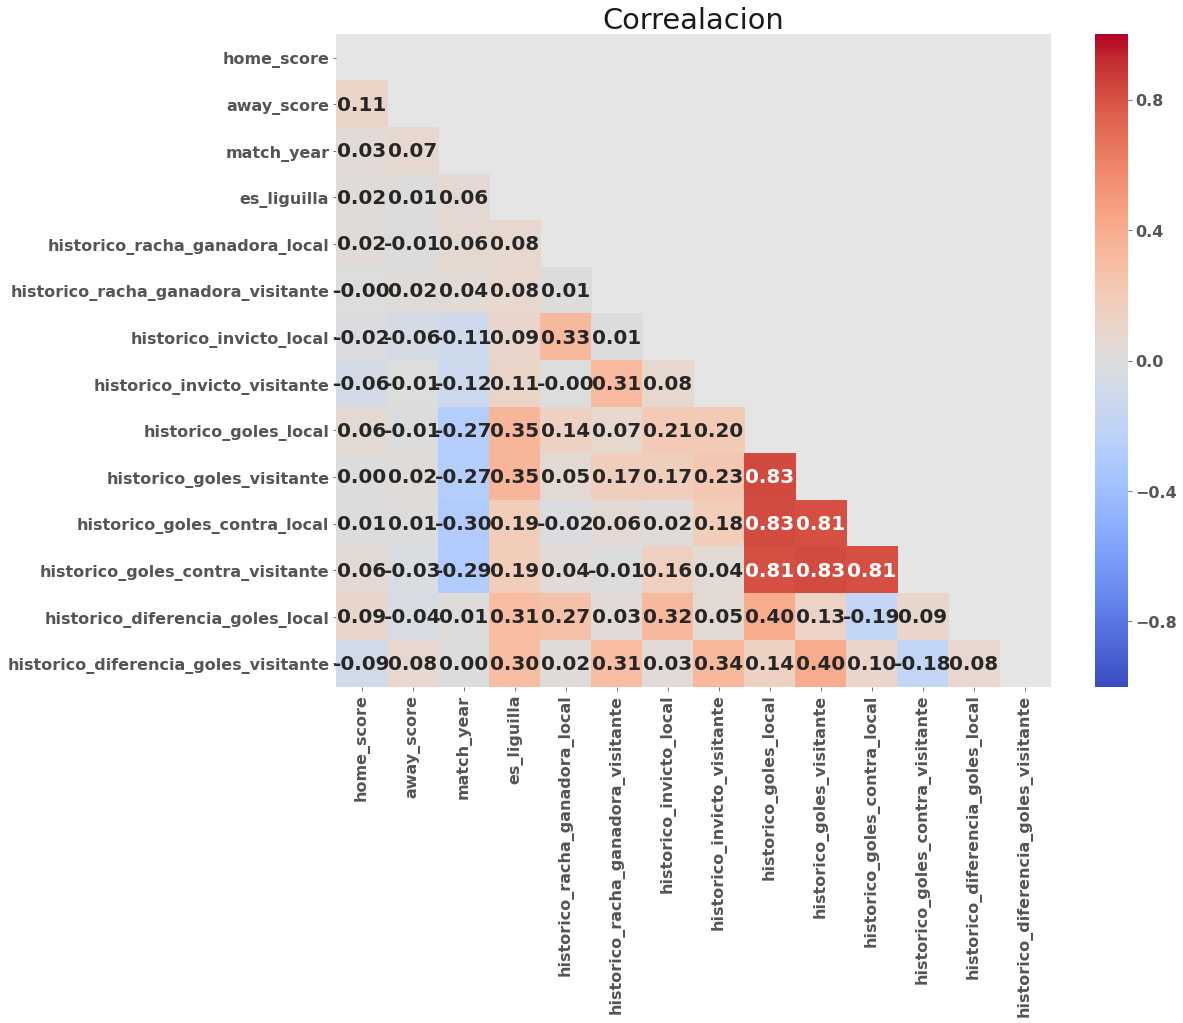

In [853]:
corr = df_semiall.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sbn.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1,vmax=1,
            mask=mask,fmt='.2f')
plt.title("Correalacion");

## Variables dummie por equipo y jornada... veamos que tal

In [854]:
df_dummies = pd.get_dummies(df_semiall, columns=['match_name','home_team','away_team','match_month','match_diasemana'])

In [860]:
df_dummies.columns

Index(['match_date', 'tournament_name', 'home_score', 'away_score',
       'match_year', 'resultado', 'FT', 'ganador', 'year_month', 'es_liguilla',
       ...
       'match_month_Noviembre', 'match_month_Octubre',
       'match_month_Septiembre', 'match_diasemana_Domingo',
       'match_diasemana_Jueves', 'match_diasemana_Lunes',
       'match_diasemana_Martes', 'match_diasemana_Miercoles',
       'match_diasemana_Sabado', 'match_diasemana_Viernes'],
      dtype='object', length=171)

In [861]:
not_x = ['year_month','match_date','tournament_name','match_year', 'resultado', 'FT', 'ganador','home_score','away_score']
x_cols = [x for x in df_dummies.columns if x not in not_x]
df_pre = df_dummies[x_cols + ['resultado']]

In [862]:
df_pre['resultado_y'] = np.where(df_pre.resultado == 'local',0,
                    np.where(df_pre.resultado == 'visitante',1,2))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Tengo duda sobre como entrenar mi modelo si con train, test y valid aleatoriamente o si es mejor como si fuese serie de tiempo

Se haran 3 modelos (cabe mencionar que no son comparables por no tener el mismo set de validacion)

1. Se generan tres conjuntos seleccionando los registros aleatoriamente.
2. Se genera el train con los primeros 18 años seleccionados secuencialmente. Valid y test se crean con los 2 últimos años de partidos y se seleccionan aleatoriamente.
3. Se genera el train con los primeros 18 años seleccionados secuencialmente. Valid se selecciona con los partidos del año 19 y test con los 
partidos del año 20.

## Escenario 1. Sin balanceo

In [863]:
x_test_valid, x_train, y_test_valid, y_train = train_test_split(
    df_pre[x_cols],
    df_pre.resultado_y,
    test_size=0.2,
    random_state=8)

x_test, x_valid, y_test, y_valid = train_test_split(x_test_valid, 
                                                    y_test_valid,
                                                    test_size = 0.5,
                                                    random_state=8)

In [864]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2561 entries, 4859 to 1197
Columns: 162 entries, es_liguilla to match_diasemana_Viernes
dtypes: float64(10), int32(1), uint8(151)
memory usage: 607.7 KB


In [865]:
d_train = lgb.Dataset(x_train, label=y_train)
d_valid = lgb.Dataset(x_valid, label=y_valid)

params = {}
params['learning_rate'] = 0.000001
params['boosting_type'] = 'gbdt'
params['objective'] = 'multiclass'
params['num_class'] = 3
params['metric'] = 'multi_logloss'
params['sub_feature'] = 0.2
params['num_leaves'] = 30
params['min_data'] = 4
params['max_depth'] = 1000
params['num_iterations'] = 60000

clf = lgb.train(params, d_train, 100, valid_sets=[d_valid], early_stopping_rounds=100, verbose_eval=10000)

Training until validation scores don't improve for 100 rounds
[10000]	valid_0's multi_logloss: 1.06785
[20000]	valid_0's multi_logloss: 1.06774
[30000]	valid_0's multi_logloss: 1.06763
[40000]	valid_0's multi_logloss: 1.06752
[50000]	valid_0's multi_logloss: 1.06741
[60000]	valid_0's multi_logloss: 1.0673
Did not meet early stopping. Best iteration is:
[60000]	valid_0's multi_logloss: 1.0673


In [867]:
y_pred=clf.predict(x_test)
predictions = []

for x in y_pred:
    predictions.append(np.argmax(x))

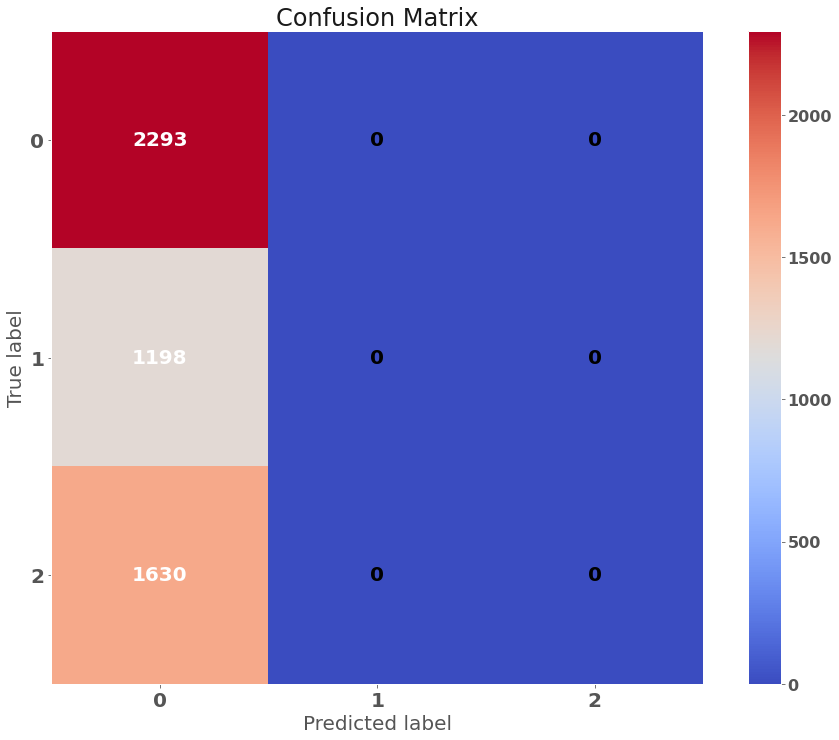

In [868]:
skplt.metrics.plot_confusion_matrix(y_test,predictions,cmap='coolwarm',normalize=False)

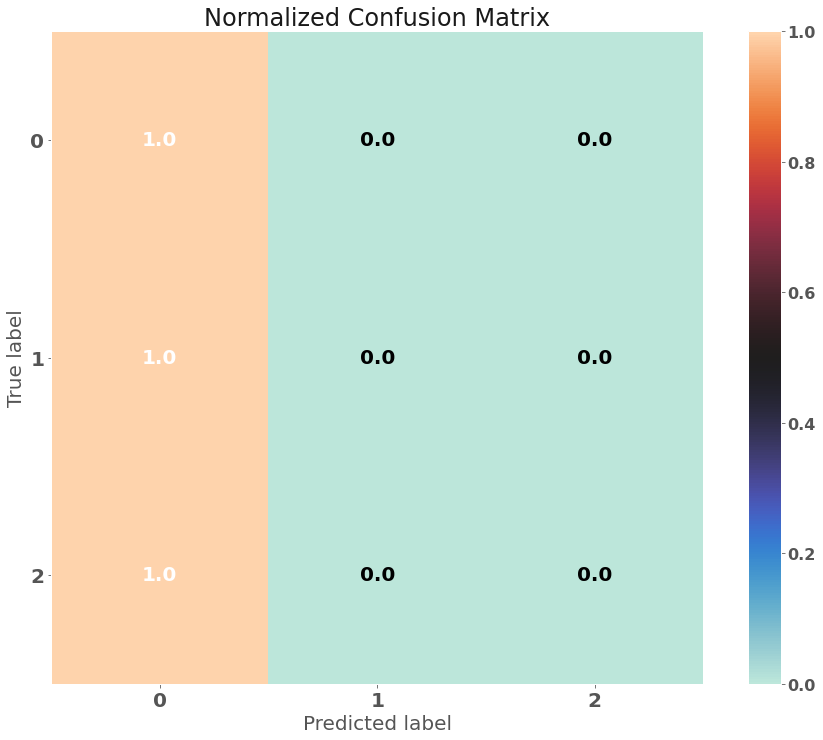

In [869]:
skplt.metrics.plot_confusion_matrix(y_test,predictions,cmap='icefire',normalize=True)

In [870]:
clf.best_score

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('multi_logloss', 1.0673034043946146)])})

In [ ]:
def multi_class_roc(class_code):

    return roc_auc_score(np.where(y_test==class_code, 1,0), 
                  [val[class_code] for val in clf.predict(x_test)])

print('roc auc score local = {0:5.5f}'.format(multi_class_roc(0)))
print('roc auc score visitante = {0:5.5f}'.format(multi_class_roc(1)))
print('roc auc score empate = {0:5.5f}'.format(multi_class_roc(2)))
print('promedio roc auc score = {0:5.5f}'.format(np.mean([multi_class_roc(0),
                                                      multi_class_roc(1),
                                                      multi_class_roc(2)])))

roc auc score local = 0.56647
roc auc score visitante = 0.56936


In [ ]:
print('accuracy score', round(accuracy_score(y_test,predictions),4))

In [ ]:
y_train.value_counts()